# Reaction rate for biphasic liquid-liquid equilibrium systems
## Context
### When working with mixtures that present liquid-liquid equilibrium, it becomes harder to determine the kinetic reaction rate of the reaction present in the system, which is why this code's goal is to determine the molar fraction in each phase, to be able to work with the main reaction rate formula
$$
V_i=\frac{k_r^{int}[E]a_{component1}a_{component_2}}{Km_{component_2}^{int}a_{component_1}+Km_{component1}^{int}a_{component_2}+a_{component_1}a_{componen_2}}
$$
### Where the reaction will have different parameters, depending on the phase that it is ocurring,since the activity terms depend on the molar fraction of each component
$$
a_i=x_i\gamma_i
$$
### Once the parameters are determined, this code can predict each component's behaviour during the reaction via an ode system, allowing to visualize with a graph how each component's quantity changes in function of time

## Libraries to import

In [1]:
#this code will predict the kinetic reaction rate of a chemical reaction in liquid-liquid equilibrium using thermodynamic activities
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import least_squares
from thermo.unifac import UNIFAC, UFSG, UFIP
from thermo.chemical import Chemical
from ugropy import Groups
import phasepy
from phasepy import mixture, component, virialgamma,unifac
from phasepy.equilibrium import lle
from thermo.unifac import UNIFAC_group_assignment_DDBST
import pubchempy as pcp
import math
from thermo.unifac import DOUFSG, DOUFIP2016, PSRKSG, PSRKIP
from scipy.integrate import solve_ivp
import re

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19


## Data insertion
### Here you insert the experimental data you want to simulate to predict it's biphasic behaviour and determine the kinetic parameters, it is important to consider the following things:
1. Temperatures in phasepy and thermo are read in Kelvin
2. Pressures in phasepy are read in Bars, but in Pascals when working with thermo
3. All components, substrates, products and solvents must be handed in a single list

In [2]:
T=30+273.15   #temperature in Kelvin
P=1.01325   #pressure in bar
components_present=[['acetic acid','hydrogen peroxide','water','toluene']]
components_initial_quantities=[[[0.6005,'mass'],[1.799,'mass'],[5.397,'mass'],[37.548,'mass']]]    #components initial load, must be in 'g' or 'mole' units


## Molar fractions determination
### This code determines the global molar fraction of each component in the system, being able to recieve quantities in mass(g) or moles
### It is important to note that when working in biphasic systems in equilibrium they are three different molar fractions, as an example, take the following molar fractions of a component "i"
$$
Z_i=0.5
$$
$$
X_i^I=0.05
$$
$$
X_i^{II}=0.75
$$
### In this case, the former component represents 50% of the moles present in the system, however, one can see that once distributed in the biphasic system, it is mostly concentrated in the second phase(75% of the moles present in it) in comparison to the first equilibrium phase(only 5%)
### This function helps to determine the global molar fraction, in other words, the concentrations one has before any reaction or biphasic distribution ocurrs(initial conditions)

In [3]:
def get_molar_fractions_zi(components,components_initial_values,T,P):
    components_moles=[]
    for i in range(len(components_initial_values)):
        if components_initial_values[i][1]=='moles':
            components_moles.append(components_initial_values[i][0])
        elif components_initial_values[i][1]=='mass':
            component=Chemical(components[i],T=T,P=P*100000)
            component_molar_mass=component.MW
            components_moles.append(components_initial_values[i][0]/component_molar_mass)
        else:
            raise ValueError("invalid unit for component initial values. Use 'mass' or 'moles'")
    total_moles=sum(components_moles)
    molar_fraction_zi=[moles/total_moles for moles in components_moles]
    return molar_fraction_zi

## Component properties 
### This code uses the phasepy library to predict the phases distributions in equilibrium, this library requires that each component is defined as an object with the following structure
$$
component_i=component(name,T_c,P_c,Z_c,V_c,w,GC)
$$
### Where the name corresponds to the component's name. $T_c$, $P_c$, $Z_c$, $V_c$, and $w$ correspond to the critical temperature, critical pressure, critical fluid compresibility, critical volume and the acentric factor of the component, respectively
### The last input that phasepy requires to define a component class is it's chemical subgroups, this is specifically the chemical subgroups fragmentation of the component based on the UNIFAC(or dortmund) fragmentation guidelines
### To obtain all this characteristics the thermo and pubchempy libraries will be used, where one must specify the pressure and temperature of operation to obtain the most precise data possible, it is crutial to note that not all components have their subgroup fragmentation correctly documented in the DDBST databanks
### To learn more about the libraries being used feel free to read their documentation
[PhasePy](https://github.com/gustavochm/phasepy/tree/master)
###
[thermo](https://thermo.readthedocs.io/index.html#)
###
[PubChempy](https://pubchempy.readthedocs.io/en/latest/)

In [4]:
def get_components_properties_alternative(components,T,P):
    #this function will return a list containing the properties of each component that are needed to define a component using phasepy
    components_properties=[]
    for i in range(len(components)):
        component=Chemical(components[i],T=T,P=P*100000)
        properties=[component.Tc,component.Pc/100000,component.Zc,component.Vc*1000000,component.omega]
        component_name=components[i]
        compound = pcp.get_compounds(component_name, 'name')[0]
        synonyms = compound.synonyms
        cas_pattern = r'^\d{2,7}-\d{2}-\d$'
        cas_numbers = [syn for syn in synonyms if re.match(cas_pattern, syn)]
        if len(cas_numbers)>0:
           cas_to_use=cas_numbers[0]
        else:
            cas_to_use=None
        subgroups_example = UNIFAC_group_assignment_DDBST(CAS=cas_to_use, model="UNIFAC")
        subgroups_named = {str(UFSG[idx])[1:-1]: count for idx, count in subgroups_example.items()}
        properties.append(subgroups_named)
        components_properties.append(properties)
    return components_properties

## Components setup
### This function recieves the properties obtained from the previous function to define the components as the phasepy object

In [5]:
#Now that we have the functions to facilitate obtaining the properties needed to define the liquid-liquid equilibrium, we can start defining our system
def set_components(components,components_properties):
    mixtures_to_use=[]
    for i in range(len(components)):
        component_to_add=component(name=components[i],Tc=components_properties[i][0],Pc=components_properties[i][1],Zc=components_properties[i][2],Vc=components_properties[i][3],w=components_properties[i][4],GC=components_properties[i][5])
        mixtures_to_use.append(component_to_add)
    return mixtures_to_use

## Example
### The following code shows the basic procedure to follow to obtain the molar fraction of each component in each phase using the functions that were defined above

In [6]:
#Now we will define our mixture
for j in range(len(components_present)):
    components_to_evaluate=components_present[j]
    components_initial_values_to_evaluate=components_initial_quantities[j]
    experiment_molar_fractions=get_molar_fractions_zi(components_to_evaluate,components_initial_values_to_evaluate,T,P)
    component_properties=get_components_properties_alternative(components_to_evaluate,T,P)
    component_properties[1][5]={'OH':2}
    mixture_to_use=set_components(components_to_evaluate,component_properties)
    #now we can define the mixture using phasepy
    mix=mixture(mixture_to_use[0],mixture_to_use[1])
    for i in range(2,len(mixture_to_use)):
       mix.add_component(mixture_to_use[i])
    #now we define the unifac model to be used
    mix.original_unifac()
    eos=virialgamma(mix, actmodel='original_unifac')
    T=T
    P=P
    Z=np.array(experiment_molar_fractions)
    x0=np.array([0.02,0.1,0.85,0.03])
    w0=np.array([0.05,0.2,0.35,0.4])
    test=lle(x0,w0,Z,T,P,eos,full_output=True)
    phase_molar_fractions=test['X']
    aqueous_phase_molar_fractions=phase_molar_fractions[0]
    organic_phase_molar_fractions=phase_molar_fractions[1]
    print("aqueous phase molar fractions:",aqueous_phase_molar_fractions)
    print("organic phase molar fractions:",organic_phase_molar_fractions)
    
    

aqueous phase molar fractions: [1.89599649e-02 1.47259444e-01 8.33309659e-01 4.70932677e-04]
organic phase molar fractions: [7.77954968e-03 1.90881825e-04 1.78974836e-03 9.90239820e-01]


## Activity coefficients 
### The kinetic reaction formula requires the activity of each substrate, where the activity is given by the following formula:
$$
a_i=x_i \gamma_i
$$
### Where $x_i$ is the molar fraction of the component i and $\gamma_i$ is it's activity coefficient
### The function requires the chemical subgroups and molar fractions of each component to determine the activity coefficients
### The function uses the original UNIFAC, modified UNIFAC(more commonly known as Dortmund) and PSRK from the thermo library
### It is important to note that when working with a biphasic system, each component has 3 different molar phases, so choose carefully which one you need


In [7]:
#this is the most crucial function of the code, it uses the thermo library to obtain the chemical subgroups present in each component and then uses the UNIFAC model of ones choosing to calculate the activity coefficients of each component in each experiment
def get_activity_coefficients(components_present,molar_fractions,chemical_subgroups,T,P,model_to_use):
    #This function will return a list of activity coefficients for each component in each experiment
    activity_coefficients=[]
    #now that we have the chemical subgroups of each component and the molar fractions of each component in each experiment, we can get the activity coefficients for each one
    if model_to_use=="UNIFAC":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=UFSG,interaction_data=UFIP,version=0)
    elif model_to_use=="MODIFIED_UNIFAC":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=DOUFSG,interaction_data=DOUFIP2016,version=1)
    elif model_to_use=="PSRK":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=PSRKSG,interaction_data=PSRKIP,version=2)
    else:
        raise ValueError("Model not recognized, please use 'UNIFAC','MODIFIED_UNIFAC' OR 'PSRK'")
           
    activity_coeffs=model.gammas()
    #we append the activity coefficients of each component of the experiment in the list
    activity_coefficients.append(activity_coeffs)  #we append the experiment number and the corresponding activity coefficients of each component
    return activity_coefficients

## Initial reaction rate 
### This function calculates the initial reaction rate for a single phase of the biphasic system where if the following assumptions can be made
1. The energy of desolvation of the active site must be independent of the solvent
2. all the enzyme states must have the same shape, volume and solubility in the media
3. the solvent does not interact with the active site and the reaction mechanism remains constant with the solvent change
### We can apply the following formula to determine the initial reaction rate
$$
V_o=\frac{K_r^{int}[E]a_{component_1}a_{component_2}}{Km_{component_2}a_{component_1}(a+\frac{a_{component_1}}{K_{iA}^{int}})+Km_{component_1}a_{component_2}+a_{component_1}a_{componen_2}}
$$
### It is important to note that this function must be applied to the reacting phase
### For more information on how this system works, feel free to read the following paper
[Elucidating solvent effects on lipase‐catalyzed peroxyacid
synthesis through activity‐based kinetics and molecular
dynamics](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/full/10.1002/bit.28762?casa_token=daiZSBAC6FwAAAAA%3AwvqFil9lK9enE9js6coXp8uFrkrIoMWNyHg79GG1CKOLF7yqSduKELJmrKbuWP4zw2g1KiQRHCocGA)

In [8]:
#This function determines the intial reaction rate of each experiment
def initial_reaction_rate(components_present,mole_fractions,activity_coeffs,params,E):
    #this function will return a list of initial reaction rates for the different experiments and plot the results
    #Comment to teach:This part would require to use a python solver to find the correct kinetic parameters from the reaction rate equation, will have preedetermined values as stand-ins for now
    #first we define the kinetic equation
    actv_first_component=mole_fractions[0]*activity_coeffs[0]  #activity of the first component in the i experiment
    actv_second_component=mole_fractions[1]*activity_coeffs[1]  #activity of the second component in the i experiment
    kr_int=params[0]  #intrinsic kinetic rate constant
    kmB_int=params[1] #rate constant for the second component
    kiA_int=params[2] #inhibitory constant for the first component
    kmA_int=params[3] #rate constant for the first component
    initial_rate_rx=(kr_int*E*actv_first_component*actv_second_component)/(kmB_int*actv_first_component*(1+actv_first_component/kiA_int)+kmA_int*actv_second_component+actv_first_component*actv_second_component)
    #we append the initial reaction rate of the i experiment
    #
    return initial_rate_rx

## System optimization
### The initial reaction rate equation usually contains constants that remain the same regardless of the components and solvent used. In order to obtain constants that best adjust to the systems that you desire to predict, this code will use a standard least squares method from the SciPy library, to learn other more complex methods of optimization feel free to view the library documentation
### This system's goal is to compare the initial reaction rates obtained experimentally with the ones predicted with the code, minimizing the square error between this two cases
### [SciPy](https://docs.scipy.org/doc/scipy/)

In [14]:
#This objective function will be used to optimize the model parameters
def objective_function(params,experimental_data,components_used,components_data,chemical_subgroups,T,P,E):
    #this function will return the sum of squared differences between the experimental initial reaction rates and the calculated ones
    calculated_data=[]
    for i in range(len(components_data)):
        molar_fractions_to_use=components_data[i]
        activity_coeffs=get_activity_coefficients(components_used,molar_fractions_to_use,chemical_subgroups,T,P,'MODIFIED_UNIFAC')
        activity_coeffs=activity_coeffs[0]
        calculated_initial_rx_rate=initial_reaction_rate(components_used,molar_fractions_to_use,activity_coeffs,params,E)
        calculated_data.append(calculated_initial_rx_rate)

    #now that we have the calculated data, we can calculate the sum of squared differences
    residuals = [calc - exp for calc, exp in zip(calculated_data, experimental_data)]    #with this we put the elements in calculated_data and experimental_data into pairs and calculate the difference between them
    return np.array(residuals)  # least_squares will minimize the sum of squares of these
#now that we defined our objective function, we can use least_squares to optimize the model parameters

In [15]:
#This function is in charge of optimizing the model parameters
def optimize_model_parameters(experimental_data,components_used,components_data,chemical_subgroups,T,P,E,initial_params):
    #this function will return the optimized model parameters
    bounds=([0, 0, 0, 0], [1, 1, 1, 1.5])   #bounds for the parameters
    result=least_squares(objective_function,initial_params, args=(experimental_data,components_used,components_data,chemical_subgroups,T,P,E), bounds=bounds)
    return result.x  #optimized parameters

## Example
### The following code shows an example on how to optimize the model parameters using a set of experimental data

In [11]:
components_for_optimization=['acetic acid','hydrogen peroxide','water','peracetic acid','hexane']
experiment_masses=[[[0.0447,'mass'],[1.799,'mass'],[5.397,'mass'],[0,'mass'],[34.323,'mass']],[[0.0944,'mass'],[1.799,'mass'],[5.397,'mass'],[0,'mass'],[34.292,'mass']],[[1.2010,'mass'],[1.799,'mass'],[5.397,'mass'],[0,'mass'],[33.595,'mass']],[[0.0447,'mass'],[3.6,'mass'],[10.8,'mass'],[0,'mass'],[33.250,'mass']],[[0.0944,'mass'],[3.6,'mass'],[10.8,'mass'],[0,'mass'],[33.218,'mass']],[[0.6005,'mass'],[3.6,'mass'],[10.8,'mass'],[0,'mass'],[32.900,'mass']],[[1.2010,'mass'],[3.6,'mass'],[10.8,'mass'],[0,'mass'],[32.522,'mass']]]
experimental_initial_rx=[0.0201,0.0923,0.16237,0.05546,0.10678,0.175,0.1728]
initial_params=[0.1,0.5,0,1]
E=0.5   #This is the enzyme concentration
#now we need to define the molar fractions of each experiment and the chemical subgroups of each component
molar_fractions_to_optimize=[]
for j in range(len(experiment_masses)):
    components_initial_values_to_evaluate=experiment_masses[j]
    experiment_molar_fractions=get_molar_fractions_zi(components_for_optimization,components_initial_values_to_evaluate,T,P)
    component_properties=get_components_properties_alternative(components_for_optimization,T,P)
    component_properties[1][5]={'OH':2}
    component_properties[3][5]={'CH3':1,'CH3CO':1,'C2H5O2':1}
    mixture_to_use=set_components(components_for_optimization,component_properties)
    #now we can define the mixture using phasepy
    mix=mixture(mixture_to_use[0],mixture_to_use[1])
    for i in range(2,len(mixture_to_use)):
       mix.add_component(mixture_to_use[i])
    #now we define the unifac model to be used
    mix.original_unifac()
    eos=virialgamma(mix, actmodel='original_unifac')
    T=T
    P=P
    Z=np.array(experiment_molar_fractions)
    x0=np.array([0.02,0.1,0.85,0.03,0])
    w0=np.array([0.05,0.2,0.35,0.4,0])
    test=lle(x0,w0,Z,T,P,eos,full_output=True)
    phase_molar_fractions=test['X']
    reaction_phase_molar_fractions=phase_molar_fractions[1]
    molar_fractions_to_optimize.append(reaction_phase_molar_fractions)

    

In [12]:
subgroups=[]
for i in range(len(component_properties)):
    subgroups.append(component_properties[i][5])    #We append the subgroups of each component in the system
subgroup_dict = UFSG     #we define the UNIFAC library subgroup dictionary
name_to_index = {str(v)[1:-1]: k for k, v in subgroup_dict.items()}   #we strip the > and < from the subgroup names and create a dictionary with the index of each subgroup name in the UNIFAC library
indexed_subgroups = []
for group_dict in subgroups:
    indexed_group_dict = {}
    for group_name, count in group_dict.items():
        if group_name in name_to_index:
            index = name_to_index[group_name]
            indexed_group_dict[index] = count
        else:
            raise ValueError(f"Group name '{group_name}' not found in the subgroup dictionary.")
    indexed_subgroups.append(indexed_group_dict)
print(indexed_subgroups)
print(molar_fractions_to_optimize[1])

[{1: 1, 42: 1}, {14: 2}, {16: 1}, {1: 1, 18: 1, 100: 1}, {1: 2, 2: 4}]
[9.17477583e-04 1.55938723e-05 7.39226715e-04 0.00000000e+00
 9.98327702e-01]


In [21]:
#now we can optimize the model parameters
optimized_params=optimize_model_parameters(experimental_initial_rx,components_for_optimization,molar_fractions_to_optimize,indexed_subgroups,T,P,E,initial_params)
print("Optimized Params: ",optimized_params)

Optimized Params:  [0.76359388 0.62033347 0.06915162 0.02452441]


## ODE system
### Once the parameters for the kinetic reaction are obtained, we can predict how each component's quantity in moles will change in function of time
### To predict this, we will assume that the statements mentioned above remain acceptable during the system's reaction, allowing us to determine the following equation to describe the component's mole change during the course of the reaction
$$
\frac{dS}{dt}=-r=\frac{K_r^{int}[E]a_{component_1}a_{component_2}}{Km_{component_2}a_{component_1}(a+\frac{a_{component_1}}{K_{iA}^{int}})+Km_{component_1}a_{component_2}+a_{component_1}a_{componen_2}}
$$
$$
\frac{dP}{dt}=r=\frac{K_r^{int}[E]a_{component_1}a_{component_2}}{Km_{component_2}a_{component_1}(a+\frac{a_{component_1}}{K_{iA}^{int}})+Km_{component_1}a_{component_2}+a_{component_1}a_{componen_2}}
$$
### Where S corresponds to substrates and P to products

In [22]:
#this is the most crucial function of the code, it uses the thermo library to obtain the chemical subgroups present in each component and then uses the UNIFAC model of ones choosing to calculate the activity coefficients of each component in each experiment
def get_activity_coefficients_alternative(components_present,molar_fractions,chemical_subgroups,T,P,model_to_use):
    #This function will return a list of activity coefficients for each component in each experiment
    activity_coefficients=[]
    if model_to_use=="UNIFAC":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=UFSG,interaction_data=UFIP,version=0)
    elif model_to_use=="MODIFIED_UNIFAC":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=DOUFSG,interaction_data=DOUFIP2016,version=1)
    elif model_to_use=="PSRK":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=PSRKSG,interaction_data=PSRKIP,version=2)
    else:
        raise ValueError("Model not recognized, please use 'UNIFAC','MODIFIED_UNIFAC' OR 'PSRK'")
           
    activity_coeffs=model.gammas()
        #we append the activity coefficients of each component of the experiment in the list
    activity_coefficients.append(activity_coeffs)  #we append the experiment number and the corresponding activity coefficients of each component
    return activity_coefficients

## ODE system accomodations
### The following function defines the ODE  system that solve_ivp will solve(click in the bottom link to view how scipy.integrate library works), since activities depend on the molar fraction of each component, this must be calculated with each evaluated time instance, since when the mole quantities change, so do the molar fractions
[scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html)

In [23]:
#now we will define the ODE system to obtain the change of product in function of time
#for this system we will assume that the total mole count remains constant, so the equations will be molar fraction as a function of time
def reaction_ode(t,S,params,T,P,components_names):
    #S corresponds to a vector containing the global moles of each component present in the system
    S_copy=[[float(S[i]),'moles'] for i in range(len(S))]
    components_molar_fractions=get_molar_fractions_zi(components_names,S_copy,T,P)
    component_properties=get_components_properties_alternative(components_names,T,P)
    component_properties[1][5]={'OH':2}
    component_properties[3][5]={'CH3':1,'CH3CO':1,'C2H5O2':1}
    mixture_to_use=set_components(components_names,component_properties)
    #now we can define the mixture using phasepy
    mix=mixture(mixture_to_use[0],mixture_to_use[1])
    for i in range(2,len(mixture_to_use)):
       mix.add_component(mixture_to_use[i])
    #now we define the unifac model to be used
    mix.original_unifac()
    eos=virialgamma(mix, actmodel='original_unifac')
    T=T
    P=P
    Z=np.array(components_molar_fractions)
    x0=np.array([0.02,0.1,0.85,0,0.03])
    w0=np.array([0.05,0.2,0.35,0,0.4])
    test=lle(x0,w0,Z,T,P,eos,full_output=True)
    phase_molar_fractions=test['X']
    reaction_phase_molar_fractions=phase_molar_fractions[1]
    subgroups=[]
    for i in range(len(component_properties)):
       subgroups.append(component_properties[i][5])
    subgroup_dict = UFSG
    name_to_index = {str(v)[1:-1]: k for k, v in subgroup_dict.items()}
    indexed_subgroups = []
    for group_dict in subgroups:
        indexed_group_dict = {}
        for group_name, count in group_dict.items():
            if group_name in name_to_index:
                index = name_to_index[group_name]
                indexed_group_dict[index] = count
            else:
                raise ValueError(f"Group name '{group_name}' not found in the subgroup dictionary.")
        indexed_subgroups.append(indexed_group_dict)
    #now we can calculate the activity coefficients
    activity_coeffs=get_activity_coefficients_alternative(components_names,reaction_phase_molar_fractions,indexed_subgroups,T,P,'MODIFIED_UNIFAC')
    #now we can define the reaction rate
    activity_coeffs=activity_coeffs[0]
    actv_first_component=reaction_phase_molar_fractions[0]*activity_coeffs[0]  #activity of the first component in the i experiment
    actv_second_component=reaction_phase_molar_fractions[1]*activity_coeffs[1]  #activity of the second component in the i experiment
    E=0.5
    kr_int,kmB_int,kiA_int,kmA_int=params
    rx_rate=(kr_int*E*actv_first_component*actv_second_component)/(kmB_int*actv_first_component*(1+actv_first_component/kiA_int)+kmA_int*actv_second_component+actv_first_component*actv_second_component)
    #now we can define the ODE system
    dSdt=[-rx_rate, -rx_rate, rx_rate, rx_rate]
    if len(S)>4:
        dSdt+=[0]*(len(S)-4) #if there are more components, we assume they do not participate in the reaction
    return dSdt


    

    

In [25]:
#now we define the initial conditions and the time span for the ODE system
S0=[0.7443549,52.88,299.5,0,398.2780852]   #in mol
component_names=['acetic acid','hydrogen peroxide','water','peracetic acid','hexane']
t_eval=np.linspace(0,250,10)
solution=solve_ivp(reaction_ode,(0,250),S0,args=(optimized_params,T,P,component_names),t_eval=t_eval)


In [27]:
print(solution.y)

[[ 7.44354900e-01  5.35397049e-02  3.13227562e-03  1.81765812e-04
   7.88778907e-06  5.73485303e-06  4.90142165e-06  8.68124581e-07
  -2.53221826e-06 -3.95248318e-05]
 [ 5.28800000e+01  5.21891848e+01  5.21387774e+01  5.21358269e+01
   5.21356530e+01  5.21356508e+01  5.21356500e+01  5.21356460e+01
   5.21356426e+01  5.21356056e+01]
 [ 2.99500000e+02  3.00190815e+02  3.00241223e+02  3.00244173e+02
   3.00244347e+02  3.00244349e+02  3.00244350e+02  3.00244354e+02
   3.00244357e+02  3.00244394e+02]
 [ 0.00000000e+00  6.90815195e-01  7.41222624e-01  7.44173134e-01
   7.44347012e-01  7.44349165e-01  7.44349999e-01  7.44354032e-01
   7.44357432e-01  7.44394425e-01]
 [ 3.98278085e+02  3.98278085e+02  3.98278085e+02  3.98278085e+02
   3.98278085e+02  3.98278085e+02  3.98278085e+02  3.98278085e+02
   3.98278085e+02  3.98278085e+02]]


## Plot

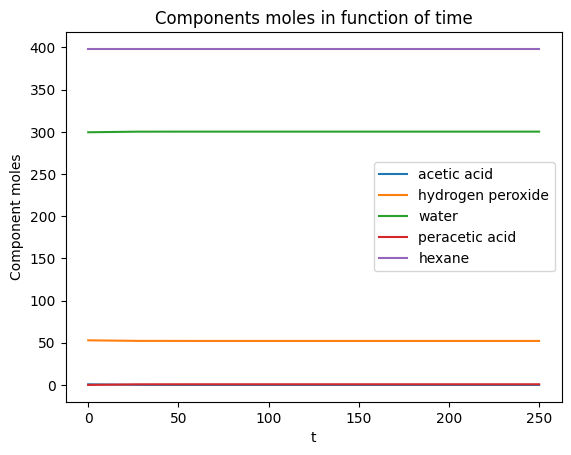

In [26]:
times_to_plot=solution.t
components_to_plot=solution.y
#now that we extracted the time intervals and the components mole quantities, we can plot the results
for i in range(len(components_to_plot)):
    plt.plot(times_to_plot,components_to_plot[i],label=component_names[i])
plt.xlabel('t')
plt.ylabel('Component moles')
plt.legend()
plt.title('Components moles in function of time')
plt.show()
